# Model without spatio temporal features

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from time import time
from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, Reshape
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split

import os, sys
import string

from urllib.request import urlretrieve

from os import mkdir, makedirs, remove, listdir

from collections import Counter

from python_utils import *


In [17]:
#loading the dataset
df = pd.read_csv("../DataSets/26_5_Final-Merged-File.csv", encoding='utf-8')

# Data preprocessing

In [18]:
pd.set_option('display.max_colwidth', -1)
df.columns
#needed are title, text, label, URL

Index(['title ', 'text', 'date', 'country', 'label', 'URL'], dtype='object')

In [19]:
df.count()

title      2901
text       2894
date       2901
country    2901
label      2901
URL        2901
dtype: int64

In [20]:
df.label.unique()

array(['FALSE', 'Pants on Fire!', 'misleading', 'Explanatory',
       'Partly false', 'Mostly False', 'PARTLY FALSE', 'MISLEADING',
       'Misleading', 'No Evidence', 'Mainly false', 'Mostly false',
       'No evidence', 'Partially false', 'Misleading/False',
       'MOSTLY TRUE', 'Partly true', 'false and misleading', 'HALF TRUE',
       'Mostly True', "(Org. doesn't apply rating)", 'Fake', 'Correct',
       'Unlikely', 'Conspiracy theory', 'Partially true', 'Not true',
       'Half True', 'MOSTLY FALSE', 'PARTLY TRUE', 'TRUE', nan],
      dtype=object)

In [21]:
#converting our problem into a binary classification problem
df['label'] = df['label'].replace({
                                        'FALSE' : 'False',
                                        'Pants on Fire!' : 'False', 
                                        'misleading': 'False',
                                        'Partly false' : 'False',
                                        'Mostly False' : 'False',
                                        'PARTLY FALSE' : 'False',
                                        'MISLEADING' : 'False',
                                        'Misleading' : 'False',
                                        'Mainly false' : 'False',
                                        'Mostly false' : 'False',
                                        'Partially false' : 'False',
                                        'Misleading/False' : 'False',
                                        'false and misleading' : 'False',
                                        'Fake' : 'False',
                                        'Unlikely' : 'False',
                                        'Not true' : 'False',
                                        'MOSTLY FALSE' : 'False',
                                        'Conspiracy theory' : 'False',
                                        'MOSTLY TRUE' : 'True',
                                        'Partly true' : 'True',
                                        'Mostly True' : 'True',
                                        'Correct' : 'True',
                                        'Half True' : 'True',
                                        'HALF TRUE' : 'True',
                                        'Partially true' : 'True',
                                        'PARTLY TRUE' : 'True',
                                        'TRUE' : 'True',
                                  })

In [22]:
df.label.value_counts()

False                          1635
True                           1236
Explanatory                    13  
No evidence                    11  
(Org. doesn't apply rating)    5   
No Evidence                    1   
Name: label, dtype: int64

In [23]:
#removing anything except 'True' or 'False'
df = df[df['label'].isin(['False', 'True'])]

In [24]:
df.label.value_counts()

False    1635
True     1236
Name: label, dtype: int64

In [25]:
df.dtypes

title      object
text       object
date       object
country    object
label      object
URL        object
dtype: object

In [26]:
df.label = df.label.map({'False':False, 'True':True})

In [27]:
df.dtypes

title      object
text       object
date       object
country    object
label      bool  
URL        object
dtype: object

# Cleaning Data

In [36]:
#converting to a text array first
all_text = []

all_text.extend(list(df.text.values))

In [37]:
all_text[:1]

['Circulating on social networks a video that shows an excerpt from a Spanish television show, supposedly issued December 24, 2019, in which it appears a woman (who claims to be psychic) ??to make "predictions". In this video, the woman describes a set of events that have been interpreted as a detailed forecast of Covid-19 pandemic that has hit the world. It is, however, a fake video, at least as regards the date of issue. The video has been being disseminated on the Internet with a date and not tampered with the real.']

In [38]:
def clean_text(txt):
    
    #removing numbers and punctuations
    text = re.sub(r"[^a-zA-Z]", ' ', txt)
    
    #removing multiple spaces
    text = re.sub(r"\s+", ' ', text)
    
    #single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    
    #converting to lower case
    text = text.lower()
    
    return text

corpus = [clean_text(str(x)) for x in all_text]

In [39]:
#testing whether the cleaning process took place successfully or not.
corpus[:1]

['circulating on social networks video that shows an excerpt from spanish television show supposedly issued december in which it appears woman who claims to be psychic to make predictions in this video the woman describes set of events that have been interpreted as detailed forecast of covid pandemic that has hit the world it is however fake video at least as regards the date of issue the video has been being disseminated on the internet with date and not tampered with the real ']

In [41]:
#counting average length of words found in the corpus

def avg_wl(txt):
    words = txt.split()
    mean = sum(len(word) for word in words)/len(words)
    
    return mean

avg_word_len = [avg_wl(sentence) for sentence in corpus]

In [43]:
df['avg_word_len'] = avg_word_len

In [47]:
#finding number of words present in each sentence within the corpus

len_sentences = [len(s.split()) for s in corpus]

In [49]:
df['len_sentences'] = len_sentences

In [52]:
df.head(1)

,title,text,date,country,label,URL,avg_word_len,len_sentences
0,A video shows a fortune teller predicting the coronavirus pandemic in December on Spanish TV.,"Circulating on social networks a video that shows an excerpt from a Spanish television show, supposedly issued December 24, 2019, in which it appears a woman (who claims to be psychic) ??to make ""predictions"". In this video, the woman describes a set of events that have been interpreted as a detailed forecast of Covid-19 pandemic that has hit the world. It is, however, a fake video, at least as regards the date of issue. The video has been being disseminated on the Internet with a date and not tampered with the real.",08-04-2020,Portugal,False,https://observador.pt/factchecks/fact-check-uma-vidente-previu-a-pandemia-da-covid-19-na-televisao-espanhola-em-dezembro/,4.795181,83


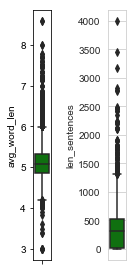

In [55]:
import seaborn as sns
l = ['avg_word_len', 'len_sentences']
number_of_columns = 2
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df[l[i]],color='green',orient='v')
    plt.tight_layout()